In [1]:
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math

2022-10-20 10:53:27.536770: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cvmfs/sft.cern.ch/lcg/releases/MCGenerators/thepeg/2.2.1-8d929/x86_64-centos7-gcc8-opt/lib/ThePEG:/cvmfs/sft.cern.ch/lcg/releases/MCGenerators/herwig++/7.2.1-f3599/x86_64-centos7-gcc8-opt/lib/Herwig:/cvmfs/sft.cern.ch/lcg/views/LCG_101/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/torch/lib:/cvmfs/sft.cern.ch/lcg/views/LCG_101/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/tensorflow:/cvmfs/sft.cern.ch/lcg/views/LCG_101/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/tensorflow/contrib/tensor_forest:/cvmfs/sft.cern.ch/lcg/views/LCG_101/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/tensorflow/python/framework:/cvmfs/sft.cern.ch/lcg/releases/java/8u222-884d8/x86_64-centos7-gcc8-opt/jre/lib/amd64:/cvmfs/sft.cern.ch/lcg/view

In [2]:
train_df = pd.read_csv('train_2Dx.csv',nrows=100000)
test_df = pd.read_csv('test_2Dx.csv',nrows=5000)

In [3]:
X_train = train_df.drop(columns=['x-midplane']).values
X_test = test_df.drop(columns=['x-midplane']).values

y_train = train_df['x-midplane'].values
y_test = test_df['x-midplane'].values

In [4]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test = scaler.fit_transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

In [5]:
model = Sequential()
model.add(Dense(32, input_shape=(168,), activation='relu')) # Add an input shape! (features,)
model.add(Dense(2, activation='linear'))
model.summary() 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                5408      
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 66        
Total params: 5,474
Trainable params: 5,474
Non-trainable params: 0
_________________________________________________________________


2022-10-20 10:53:46.902435: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cvmfs/sft.cern.ch/lcg/releases/MCGenerators/thepeg/2.2.1-8d929/x86_64-centos7-gcc8-opt/lib/ThePEG:/cvmfs/sft.cern.ch/lcg/releases/MCGenerators/herwig++/7.2.1-f3599/x86_64-centos7-gcc8-opt/lib/Herwig:/cvmfs/sft.cern.ch/lcg/views/LCG_101/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/torch/lib:/cvmfs/sft.cern.ch/lcg/views/LCG_101/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/tensorflow:/cvmfs/sft.cern.ch/lcg/views/LCG_101/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/tensorflow/contrib/tensor_forest:/cvmfs/sft.cern.ch/lcg/views/LCG_101/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/tensorflow/python/framework:/cvmfs/sft.cern.ch/lcg/releases/java/8u222-884d8/x86_64-centos7-gcc8-opt/jre/lib/amd64:/cvmfs/sft.cern.ch/lcg/views/LCG_101/

In [6]:
def custom_loss(y, p):
    
    maxval = 1e6
    minval = 1e-9
    pi = 3.14159265359
    
    mu = tf.gather(params=p, indices=[0], axis=1)
    sigma = tf.clip_by_value(tf.gather(params=p, indices=[1], axis=1),minval,maxval)
        
    term = tf.clip_by_value(1.0/tf.math.sqrt(2*pi)/sigma*tf.math.exp(-1*(y-mu)*(y-mu)/(2*sigma*sigma)),minval,maxval)
    NLL = tf.clip_by_value(-1*tf.math.log(term),minval,maxval)
    
    return tf.keras.backend.sum(NLL,axis=1)

In [7]:
model.compile(optimizer='Adam', 
              loss=custom_loss)

In [8]:
es = EarlyStopping(patience=5)

history = model.fit(X_train,
                    y_train,
                    callbacks=[es],
                    epochs=80, 
                    batch_size=64,
                    validation_split=0.2,
                    shuffle=True,
                    verbose=1)

2022-10-20 10:53:47.159471: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 53760000 exceeds 10% of free system memory.
2022-10-20 10:53:47.313980: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-10-20 10:53:47.333370: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2894560000 Hz


Epoch 1/80
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
1250/1250 [==============================] - 3s 1ms/step - loss: 7.4930 - val_loss: 4.4014
Epoch 2/80
1250/1250 [==============================] - 1s 1ms/step - loss: 4.0825 - val_loss: 3.8429
Epoch 3/80
1250/1250 [==============================] - 1s 979us/step - loss: 3.6743 - val_loss: 3.5657
Epoch 4/80
1250/1250 [==============================] - 1s 1ms/step - loss: 3.4852 - val_loss: 3.4470
Epoch 5/80
1250/1250 [==============================] - 1s 1ms/step - loss: 3.3931 - val_loss: 3.3812
Epoch 6/80
1250/1250 [==============================] - 1s 1ms/step - loss: 3.3353 - val_loss: 3.3341
Epoch 7/80
1250/1250 [==============================] - 1s 1ms/step - loss: 3.2925 - val_loss: 3.2970
Epoch 8/80
1250/1250 [==============================] - 1s 1ms/step - loss: 3.2600 - val_loss: 3.2714
Epoch 9/80
1250/1250 [======================

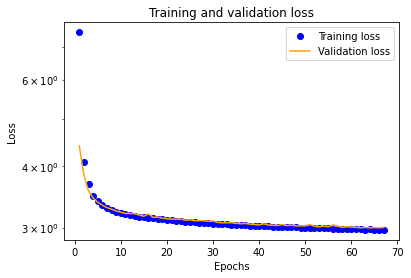

In [9]:
history_dict = history.history
loss_values = history_dict['loss'] 
val_loss_values = history_dict['val_loss'] 
epochs = range(1, len(loss_values) + 1) 
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale('Log')
plt.legend()
#plt.savefig('/home/jieun201/fullprecision400e_yprofile/loss.png')

In [10]:
model.save('models_2Dx/gausstest.keras')

In [11]:
p_test = model.predict(X_test)
np.savetxt("test_2DxGaus.csv", p_test, delimiter=",")

In [20]:
residuals = y_test - p_test[:,0]
print(np.mean(residuals),np.std(residuals))

1.3650875357429892 10.545521369548577


In [ ]:
uncertainty= p_test[:,1]
print(np.mean(uncertainty),np.std(uncertainty))

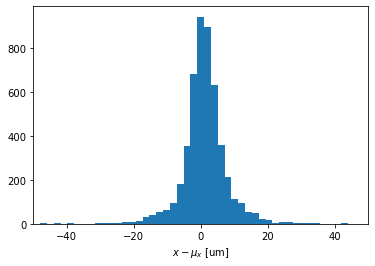

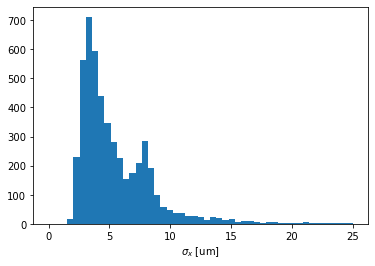

In [19]:
plt.hist(residuals,bins=np.linspace(-50,50,50))
#plt.yscale('Log')
plt.xlabel(r'$x-\mu_x$ [um]')
plt.xlim(-50,50)
plt.show()

plt.hist(uncertainty,bins=np.linspace(0,25,50));
#plt.yscale('Log')
plt.xlabel(r'$\sigma_x$ [um]')
plt.show()

In [14]:
pulls = residuals/p_test[:,1]
print(np.mean(pulls),np.std(pulls))

0.25096188160366595 1.0809123505052174


Text(0.5, 0, 'pull')

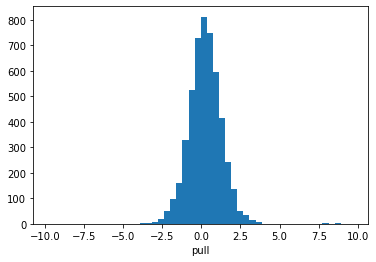

In [15]:
plt.hist(pulls,bins=50);
plt.xlabel('pull')

In [29]:
df_2d = pd.DataFrame(p_test,columns=['mu','sigma'])
df_2d['xtrue'] = y_test
df_2d.head()

,mu,sigma,xtrue
0,14.907436,15.446582,42.208390
1,18.606249,5.295032,17.997472
2,-25.734352,4.052320,-24.593676
3,53.499668,2.637384,51.074354
4,-47.963978,9.514785,-49.220710


In [32]:
df_1d = pd.read_csv('test_1DxGaus.csv',header=None,names=['mu','sigma','xtrue'])
df_1d.head()

,mu,sigma,xtrue
0,26.349080,6.142230,35.970951
1,0.378971,5.937604,0.770363
2,-34.030136,6.684201,-37.471662
3,-21.850067,5.399169,-10.147963
4,-70.883240,4.519870,-73.204875


Text(0.5, 0, '$x-\\mu_x$ [um]')

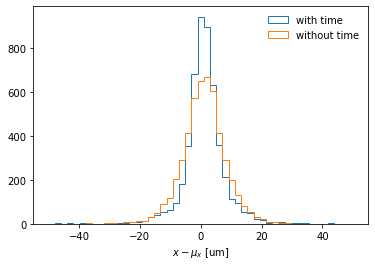

In [39]:
plt.hist(df_2d['xtrue'] - df_2d['mu'],histtype='step',bins=np.linspace(-50,50,50),label=r'with time');
plt.hist(df_1d['xtrue'] - df_1d['mu'],histtype='step',bins=np.linspace(-50,50,50),label=r'without time');
plt.legend(frameon=False)
plt.xlabel(r'$x-\mu_x$ [um]')

Text(0.5, 0, '$\\sigma_x$ [um]')

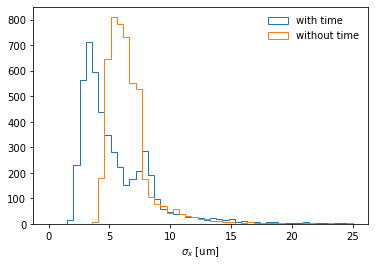

In [41]:
plt.hist(df_2d['sigma'],histtype='step',bins=np.linspace(0,25,50),label=r'with time');
plt.hist(df_1d['sigma'],histtype='step',bins=np.linspace(0,25,50),label=r'without time');
plt.legend(frameon=False)
plt.xlabel(r'$\sigma_x$ [um]')

Text(0.5, 0, 'true x [um]')

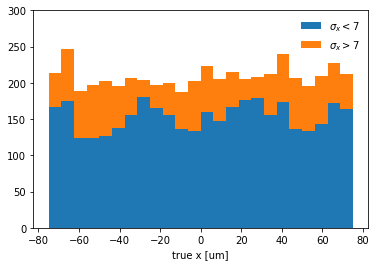

In [59]:
plt.hist([df_2d[df_2d['sigma']<7]['xtrue'],df_2d[df_2d['sigma']>7]['xtrue']],bins=np.linspace(-75,75,25),stacked=True,label=['$\sigma_x<7$','$\sigma_x>7$']);
plt.ylim(0,300)
plt.legend(frameon=False)
plt.xlabel('true x [um]')

Text(0, 0.5, '$\\sigma_x$ [um]')

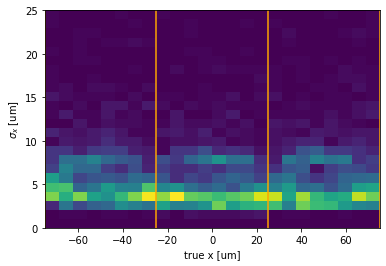

In [75]:
plt.hist2d(df_2d['xtrue'],df_2d['sigma'],bins=[np.linspace(-75,75,25),np.linspace(0,25,25)]);
#plt.plot([0,0],[0,25],color='orange')
plt.plot([-75,-75],[0,25],color='orange')
#plt.plot([-50,-50],[0,25],color='orange',linestyle='--')
plt.plot([-25,-25],[0,25],color='orange')
plt.plot([25,25],[0,25],color='orange')
#plt.plot([50,50],[0,25],color='orange',linestyle='--')
plt.plot([75,75],[0,25],color='orange')
plt.xlabel('true x [um]')
plt.ylabel(r'$\sigma_x$ [um]')